In [3]:
import numpy as np
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import accuracy_score, classification_report
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.optimizers import Adam

In [4]:
df = pd.read_csv("/kaggle/input/sentiment140/training.1600000.processed.noemoticon.csv", 
                 encoding="latin-1", header=None)  

In [5]:
df.head()

,0,1,2,3,4,5
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [6]:
df.columns = ["sentiment", "id", "date", "query", "user", "text"]

In [7]:
df = df[["sentiment", "text"]]

In [8]:
df["sentiment"] = df["sentiment"].map({0: 0, 4: 1})

In [9]:
df.head()

,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [10]:
stop_words = set(stopwords.words('english'))

In [11]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+|https\S+", '', text, flags=re.MULTILINE)
    text = re.sub(r'\@\w+|\#','', text)
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    words = word_tokenize(text)
    words = [word for word in words if word not in stop_words]
    return " ".join(words)

In [12]:
df["cleaned_text"] = df["text"].apply(clean_text)

In [13]:
df.head()

,sentiment,text,cleaned_text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",thats bummer shoulda got david carr third day
1,0,is upset that he can't update his Facebook by ...,upset cant update facebook texting might cry r...
2,0,@Kenichan I dived many times for the ball. Man...,dived many times ball managed save rest go bounds
3,0,my whole body feels itchy and like its on fire,whole body feels itchy like fire
4,0,"@nationwideclass no, it's not behaving at all....",behaving im mad cant see


In [14]:
MAX_VOCAB_SIZE = 20000
MAX_SEQUENCE_LENGTH = 50

In [15]:
tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE, oov_token="<OOV>")
tokenizer.fit_on_texts(df["cleaned_text"])

In [16]:
sequences = tokenizer.texts_to_sequences(df["cleaned_text"])

In [17]:
padded_sequences = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH, padding="post")

In [18]:
print(f"Sample original text: {df['cleaned_text'].iloc[0]}")
print(f"Tokenized sequence: {sequences[0]}")
print(f"Padded sequence: {padded_sequences[0]}")

Sample original text: thats bummer shoulda got david carr third day
Tokenized sequence: [44, 1088, 3297, 8, 753, 9568, 1722, 4]
Padded sequence: [  44 1088 3297    8  753 9568 1722    4    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0]


In [19]:
labels = np.array(df["sentiment"])

In [20]:
X_train, X_val, y_train, y_val = train_test_split(padded_sequences, labels, test_size=0.2, random_state=42)

In [21]:
X_train = tf.cast(X_train, tf.float32)
X_val = tf.cast(X_val, tf.float32)

In [22]:
y_train = tf.cast(y_train, tf.int32)
y_val = tf.cast(y_val, tf.int32)

In [23]:
print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")

Training set: (1280000, 50), (1280000,)
Validation set: (320000, 50), (320000,)


In [29]:
from tensorflow.keras import mixed_precision
mixed_precision.set_global_policy('mixed_float16')

In [30]:
from tensorflow.keras.mixed_precision import LossScaleOptimizer
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_accuracy', patience=2, restore_best_weights=True)

layer = BatchNormalization(dtype='float32')

opt = Adam(learning_rate=1e-3)
opt = LossScaleOptimizer(opt)

In [31]:
vocab_size = len(tokenizer.word_index) + 1
max_len = X_train.shape[1]

model = Sequential([
    Embedding(vocab_size, 128, input_length=max_len),
    LSTM(64, return_sequences=True),
    Dropout(0.2),
    LSTM(64),
    Dropout(0.3),
    layer,
    Dense(1, activation='sigmoid')
])

optimizer = Adam(learning_rate=0.0005)
# model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy'])
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

In [32]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ ?                           │     0 (unbuilt) │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [33]:
history = model.fit(X_train, y_train, epochs=7, batch_size=32, validation_data=(X_val, y_val), callbacks=[early_stopping])

Epoch 1/7
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 1435s 36ms/step - accuracy: 0.7440 - loss: 0.5091 - val_accuracy: 0.7794 - val_loss: 0.4626
Epoch 2/7
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 1425s 36ms/step - accuracy: 0.7841 - loss: 0.4581 - val_accuracy: 0.7808 - val_loss: 0.4568
Epoch 3/7
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 1426s 36ms/step - accuracy: 0.7929 - loss: 0.4441 - val_accuracy: 0.7888 - val_loss: 0.4473
Epoch 4/7
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 1428s 36ms/step - accuracy: 0.7993 - loss: 0.4327 - val_accuracy: 0.7895 - val_loss: 0.4451
Epoch 5/7
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 1427s 36ms/step - accuracy: 0.8063 - loss: 0.4213 - val_accuracy: 0.7895 - val_loss: 0.4469
Epoch 6/7
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 1428s 36ms/step - accuracy: 0.8129 - loss: 0.4100 - val_accuracy: 0.7855 - val_loss: 0.4573
Epoch 7/7
40000/40000 ━━━━━━━━━━━━━━━━━━━━ 1426s 36ms/step - accuracy: 0.8188 - loss: 0.3999 - val_accuracy: 0.7858 - val_loss: 0.4586


In [34]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (32, 50, 128)               │      53,491,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (32, 50, 64)                │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (32, 50, 64)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (32, 64)                    │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (32, 64)                    │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (32, 64)                    │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (32, 1)                     │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 160,723,145 (613.11 MB)

 Trainable params: 53,574,337 (204.37 MB)

 Non-trainable params: 128 (512.00 B)

 Optimizer params: 107,148,680 (408.74 MB)

In [35]:
y_pred = model.predict(X_val)
y_pred = (y_pred > 0.5).astype(int)

10000/10000 ━━━━━━━━━━━━━━━━━━━━ 27s 3ms/step


In [36]:
accuracy = accuracy_score(y_val, y_pred)
print(f"Validation Accuracy: {accuracy:.4f}")

Validation Accuracy: 0.7858


In [37]:
print("Classification Report:\n", classification_report(y_val, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.77      0.78    159494
           1       0.78      0.80      0.79    160506

    accuracy                           0.79    320000
   macro avg       0.79      0.79      0.79    320000
weighted avg       0.79      0.79      0.79    320000



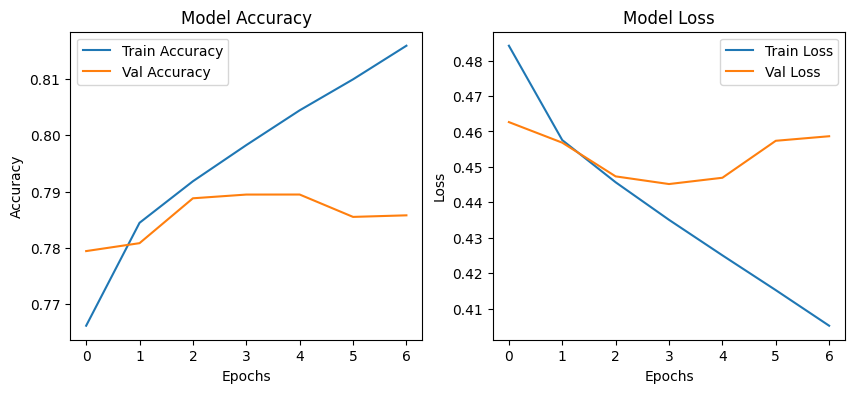

In [40]:
import matplotlib.pyplot as plt

history_dict = history.history

plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Model Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Model Loss')

plt.show()

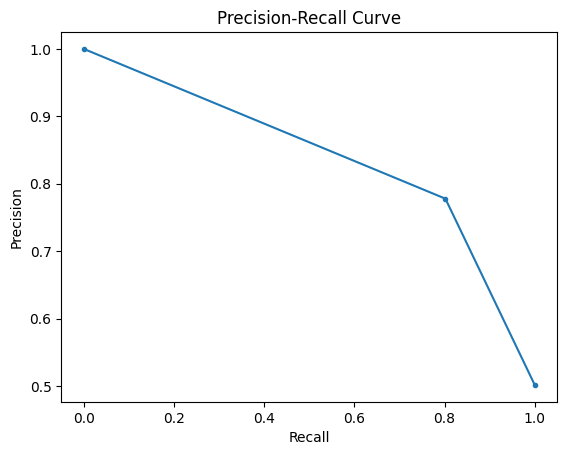

In [42]:
from sklearn.metrics import precision_recall_curve

precision, recall, _ = precision_recall_curve(y_val, y_pred)

plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

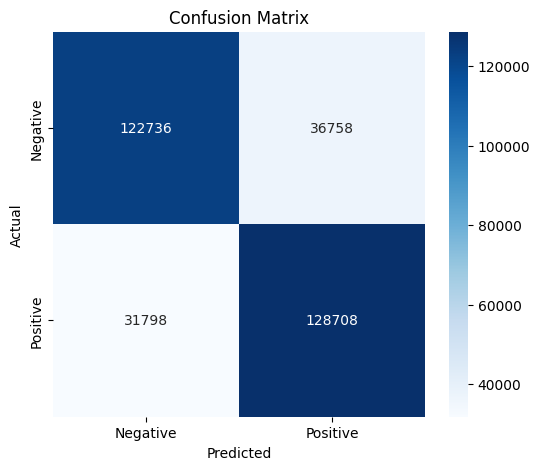

In [39]:
import seaborn as sns
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_val, y_pred)

plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

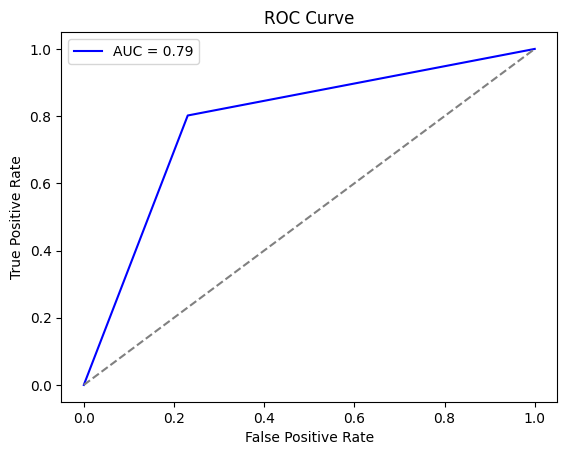

In [43]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, _ = roc_curve(y_val, y_pred)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

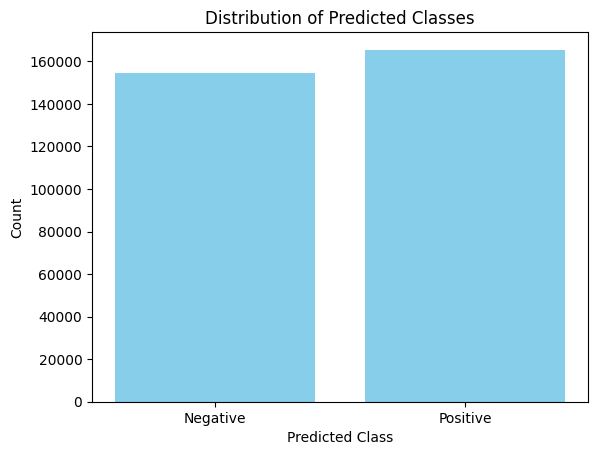

In [44]:
y_pred_labels = (y_pred > 0.5).astype(int)

plt.hist(y_pred_labels, bins=np.arange(-0.5, 2, 1), rwidth=0.8, color='skyblue')
plt.xticks([0, 1], labels=['Negative', 'Positive'])
plt.xlabel('Predicted Class')
plt.ylabel('Count')
plt.title('Distribution of Predicted Classes')
plt.show()